# Project Objective

Predict the insurance charges for an individual from given dataset and state some insights derived from data exploration and analysis.

## Libraries

In [12]:
#Libraries
import os
import pandas as pd
import numpy as np 
import math

#plotly
# Plotly Packages
from plotly import tools
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression  
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer

from pandas import DataFrame
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV 


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

## Data Understanding

In [13]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [14]:
#No. of missing values
df.isnull().sum().max()

0

In [21]:
#Observing the target variable distribution
charge_dist = df["charges"].values
logcharge = np.log(df["charges"])
trace0 = go.Histogram(
    x=charge_dist,
    histnorm='probability',
    name="Charges Distribution",
    marker = dict(
        color = '#FA5858',
    )
)

trace1 = go.Histogram(
    x=logcharge,
    histnorm='probability',
    name="Charges Distribution using Log",
    marker = dict(
        color = 'Cyan',
    )
)

fig = tools.make_subplots(rows=2, cols=1,
                          subplot_titles=('Charge Distribution','Log Charge Distribution'),
                         print_grid=False)



fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)


fig['layout'].update(showlegend=True, title='Charge Distribution', bargap=0.05)
iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

### Charge Dstribution
From thge above plot we can see that the charge distribution is right skewed with most of the people having charges between 2K to 14K

## Exploratory Data Analysis

In [20]:
corr = df.corr()

hm = go.Heatmap(
    z=corr.values,
    x=corr.index.values.tolist(),
    y=corr.index.values.tolist()
)


data = [hm]
layout = go.Layout(title="Correlation Heatmap")

fig = dict(data=data, layout=layout)
iplot(fig, filename='labelled-heatmap')

### Correlation:

Age has a correlation of 0.29 with charges. And BMI has a 

## Handling categorical data

Converting the features 'sex' and 'smoker' to numerical.

In [4]:
def Oenc(cols):
    ord_enc = OrdinalEncoder()
    for column in cols:
        df[column] = ord_enc.fit_transform(df[[column]])
    return df

In [5]:
cols = ['sex','smoker']
Oenc(cols)

,age,sex,bmi,children,smoker,region,charges
0,19,0.0,27.900,0,1.0,southwest,16884.92400
1,18,1.0,33.770,1,0.0,southeast,1725.55230
2,28,1.0,33.000,3,0.0,southeast,4449.46200
3,33,1.0,22.705,0,0.0,northwest,21984.47061
4,32,1.0,28.880,0,0.0,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,1.0,30.970,3,0.0,northwest,10600.54830
1334,18,0.0,31.920,0,0.0,northeast,2205.98080
1335,18,0.0,36.850,0,0.0,southeast,1629.83350
1336,21,0.0,25.800,0,0.0,southwest,2007.94500


In [100]:
oe = OneHotEncoder(sparse=False)
df[['northeast','northwest','southeast','southwest']] = oe.fit_transform(df['region'].values.reshape(-1,1))


In [101]:
df.head(20)

,age,bmi,children,region,charges,sex_code,smoker_code,northeast,northwest,southeast,southwest
0,19,27.900,0,southwest,16884.92400,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.770,1,southeast,1725.55230,1.0,0.0,0.0,0.0,1.0,0.0
2,28,33.000,3,southeast,4449.46200,1.0,0.0,0.0,0.0,1.0,0.0
3,33,22.705,0,northwest,21984.47061,1.0,0.0,0.0,1.0,0.0,0.0
4,32,28.880,0,northwest,3866.85520,1.0,0.0,0.0,1.0,0.0,0.0
5,31,25.740,0,southeast,3756.62160,0.0,0.0,0.0,0.0,1.0,0.0
6,46,33.440,1,southeast,8240.58960,0.0,0.0,0.0,0.0,1.0,0.0
7,37,27.740,3,northwest,7281.50560,0.0,0.0,0.0,1.0,0.0,0.0
8,37,29.830,2,northeast,6406.41070,1.0,0.0,1.0,0.0,0.0,0.0
9,60,25.840,0,northwest,28923.13692,0.0,0.0,0.0,1.0,0.0,0.0


In [102]:
df.drop(['region'], axis=1, inplace=True)

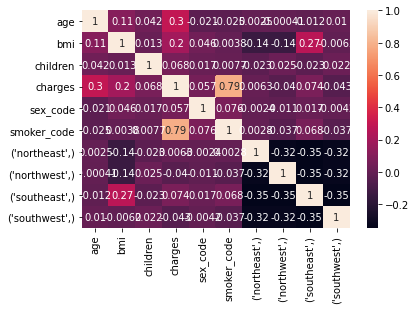

In [52]:
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

## Exploratory Data Analysis

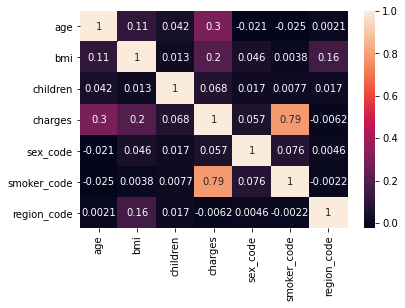

In [16]:
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

<AxesSubplot:xlabel='age', ylabel='charges'>

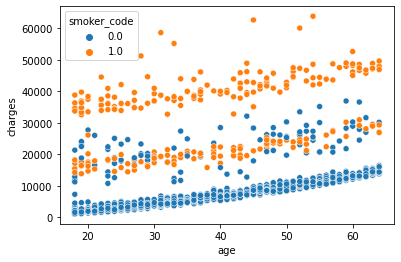

In [33]:
# (Smoker code, age, BMI) VS charges, BMI vs region code
sns.scatterplot(x='age', y='charges', data=df, hue='smoker_code')

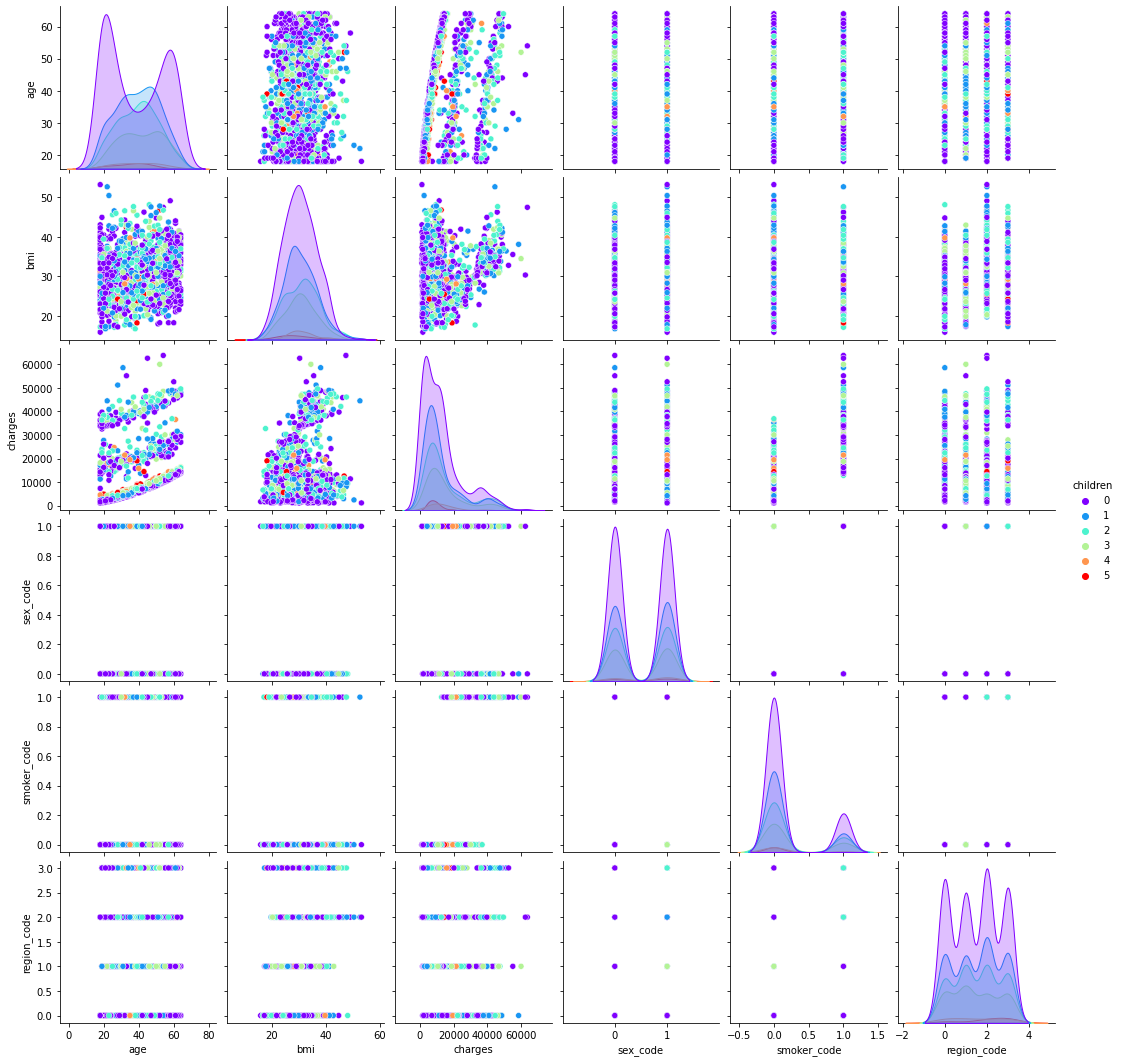

In [35]:
sns.pairplot(df, hue="children", palette="rainbow")

In [ ]:
fig,ax = plt.subplots(2,2, figsize=(15,15))
plot = sns.scatterplot(x="smoker", y="t1",hue = 'season',data=data_frame,ax= ax[0,0])
plot.set_title("Bike Share count VS Temparature")

Text(0.5, 1.0, 'bmi VS Charge for regions')

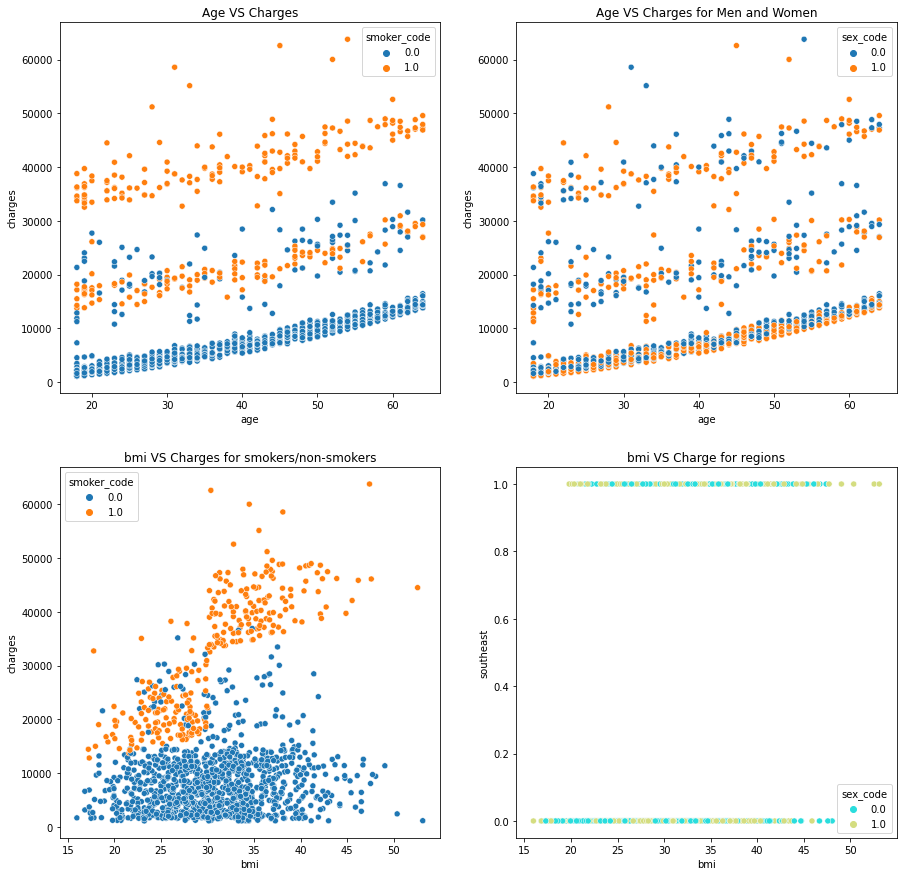

In [72]:
fig,ax = plt.subplots(2,2, figsize=(15,15))
plot = sns.scatterplot(x="age", y="charges",hue = 'smoker_code',data=df,ax= ax[0,0])
plot.set_title("Age VS Charges")
plot = sns.scatterplot(x="age", y="charges",hue = 'sex_code',data=df,ax= ax[0,1])
plot.set_title("Age VS Charges for Men and Women") 
plot = sns.scatterplot(x="bmi", y="charges",hue = 'smoker_code',data=df,ax= ax[1,0])
plot.set_title("bmi VS Charges for smokers/non-smokers") 
plot = sns.scatterplot(x="bmi", y="southeast",hue = 'sex_code',data=df,ax= ax[1,1], palette="rainbow")
plot.set_title("bmi VS Charge for regions") 

### Graph1: Age VS Charges for Smokers and non smokers
    From Graph 1, we can observe that smokers that are older have more charge. And non smokers that are younger has least charges.
### Graph 2: Age VS Charges for Men and Women
    From Graph 2, we can observe that
### Graph 3: bmi VS Charges for smokers/non-smokers
    From Graph 3, people with large BMI, who smoke have highest charges compared to people with less bmi, who are non smokers.
### Graph 4: bmi VS southeast region
    From Graph 4, majority of southeast people that are male seem to have high bmi.

## Feautre Scaling

The columns, age,bmi,children,charges are 

In [103]:
# function to normalize the features
def Normalize_Function(df, columns):
    # apply standardization on numerical features
    for column in columns:
        # fit on training data column
        scale = MinMaxScaler().fit(df[[column]])    
        # transform the training data column
        df[column] = scale.transform(df[[column]])
    
    return df      

In [104]:
cols = ['age','bmi','children']

Normalize_Function(df, cols)

,age,bmi,children,charges,sex_code,smoker_code,northeast,northwest,southeast,southwest
0,0.021739,0.321227,0.0,16884.92400,0.0,1.0,0.0,0.0,0.0,1.0
1,0.000000,0.479150,0.2,1725.55230,1.0,0.0,0.0,0.0,1.0,0.0
2,0.217391,0.458434,0.6,4449.46200,1.0,0.0,0.0,0.0,1.0,0.0
3,0.326087,0.181464,0.0,21984.47061,1.0,0.0,0.0,1.0,0.0,0.0
4,0.304348,0.347592,0.0,3866.85520,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1333,0.695652,0.403820,0.6,10600.54830,1.0,0.0,0.0,1.0,0.0,0.0
1334,0.000000,0.429379,0.0,2205.98080,0.0,0.0,1.0,0.0,0.0,0.0
1335,0.000000,0.562012,0.0,1629.83350,0.0,0.0,0.0,0.0,1.0,0.0
1336,0.065217,0.264730,0.0,2007.94500,0.0,0.0,0.0,0.0,0.0,1.0


## Performance tuning

In [108]:
# splitting the data frame into Features and Target varibale for Testing  and Training the model 
X = df.drop(columns=['charges'], axis=0)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(df.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1338, 10)
(936, 9)
(402, 9)
(936,)
(402,)


## Evaluation metrics MSE RMSE

In [111]:
# Function to Generate the MSE, RMSE
def mse_rmse(trues, preds):
    mse = np.sum(np.square(trues - preds), axis=0) / trues.shape[0]
    rmse = np.sqrt(mse)
    return mse, rmse


def rmse_scorer(trues, preds):
    mse, rmse = mse_rmse(trues, preds)
    return rmse
# Make the scoring function for GridSearch
rmse_scoring = make_scorer(rmse_scorer, greater_is_better=False)

In [112]:
# Creating the dataframe for model evaluation metric results
Models_Performance = pd.DataFrame(columns=['Model', 'MSE','Tuning Parameters', 'RMSE'])

In [113]:
def Alpha_Generator(RangeMin, RangeMax):
    base = 2 
    steps =20
    bottom =math.log(RangeMin,base)
    top = math.log(RangeMax,base)
    exps = np.arange(bottom, top, (top-bottom)/steps)
    alphas = [np.power(base, ex) for ex in exps]
    alphas
    return alphas


In [114]:
# Linear Regression Model

lm = LinearRegression().fit(X_train, y_train)
lm_pred=lm.predict(X_test)

Linear_MSE, Linear_RMSE=  mse_rmse(y_test, lm_pred)

print("Linear_MSE =", Linear_MSE)
print("Linear_RMSE=", Linear_RMSE)

data =[{'Model': 'Linear_Regression','MSE':Linear_MSE,'Tuning Parameters':'none','RMSE': Linear_RMSE }]
Models_Performance= Models_Performance.append(data, ignore_index=True,sort=False)

Models_Performance

Linear_MSE = 33780509.574791655
Linear_RMSE= 5812.100272258872


,Model,MSE,Tuning Parameters,RMSE
0,Linear_Regression,3.378051e+07,none,5812.100272


In [117]:
lasso = Lasso()
lasso.fit(X_train, y_train)

lasso_pred=lasso.predict(X_test)

lasso_MSE, lasso_RMSE=  mse_rmse(y_test, lasso_pred)

print("lasso_MSE =", lasso_MSE)
print("lasso_RMSE=", lasso_RMSE)

data =[{'Model': 'Lasso','MSE':lasso_MSE,'Tuning Parameters':'none','RMSE': lasso_RMSE }]
Models_Performance=Models_Performance.append(data, ignore_index=True,sort=False)
Models_Performance

lasso_MSE = 33779702.64664074
lasso_RMSE= 5812.0308538961435


,Model,MSE,Tuning Parameters,RMSE
0,Linear_Regression,3.378051e+07,none,5812.100272
1,Lasso,3.377970e+07,none,5812.030854


In [120]:
# generating alpha values

alphas=Alpha_Generator(1e-4, 1)
alphas

[0.00010000000000000005,
 0.00015848931924611147,
 0.00025118864315095833,
 0.0003981071705534979,
 0.0006309573444801946,
 0.0010000000000000024,
 0.0015848931924611182,
 0.0025118864315095885,
 0.003981071705534987,
 0.006309573444801959,
 0.010000000000000045,
 0.015848931924611214,
 0.025118864315095937,
 0.039810717055349956,
 0.06309573444801972,
 0.10000000000000066,
 0.15848931924611245,
 0.25118864315095984,
 0.39810717055350037,
 0.6309573444801985]

In [121]:
# Applying the GridsearchCV with alpha and CrossValidation

param_grid = [{'alpha':alphas}]
grid_search = GridSearchCV(estimator=lasso,
                           param_grid=param_grid,
                           scoring=rmse_scoring,
                           n_jobs=-1,
                           verbose= 1,cv=10)

grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=10, estimator=Lasso(), n_jobs=-1,
             param_grid=[{'alpha': [0.00010000000000000005,
                                    0.00015848931924611147,
                                    0.00025118864315095833,
                                    0.0003981071705534979,
                                    0.0006309573444801946,
                                    0.0010000000000000024,
                                    0.0015848931924611182,
                                    0.0025118864315095885, 0.003981071705534987,
                                    0.006309573444801959, 0.010000000000000045,
                                    0.015848931924611214, 0.025118864315095937,
                                    0.039810717055349956, 0.06309573444801972,
                                    0.10000000000000066, 0.15848931924611245,
                                    0.25118864315095984, 0.39810717055350037,
                                    0.6309573444801985]}],

In [122]:
stats = grid_search.cv_results_

In [123]:
Lasso_df = DataFrame(stats)
Lasso_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.041555,0.032230,0.025436,0.016526,0.000100,{'alpha': 0.00010000000000000005},-6791.744085,-5259.114588,-6217.854680,-5618.685544,-6623.040336,-6329.303544,-6267.756735,-6662.252036,-6158.246484,-5925.823936,-6185.382197,454.136679,20
1,0.009648,0.004335,0.004489,0.001632,0.000158,{'alpha': 0.00015848931924611147},-6791.744038,-5259.114609,-6217.854752,-5618.685483,-6623.040249,-6329.303587,-6267.756671,-6662.252014,-6158.246455,-5925.823970,-6185.382183,454.136664,19
2,0.005679,0.003557,0.003122,0.001098,0.000251,{'alpha': 0.00025118864315095833},-6791.743963,-5259.114634,-6217.854590,-5618.685386,-6623.040110,-6329.303655,-6267.756571,-6662.251980,-6158.246408,-5925.824024,-6185.382132,454.136640,18
3,0.005195,0.003994,0.002086,0.000369,0.000398,{'alpha': 0.0003981071705534979},-6791.743845,-5259.114674,-6217.854772,-5618.685233,-6623.039891,-6329.303764,-6267.756400,-6662.251926,-6158.246334,-5925.824110,-6185.382095,454.136606,17
4,0.005979,0.004403,0.003046,0.000632,0.000631,{'alpha': 0.0006309573444801946},-6791.743656,-5259.114738,-6217.855059,-5618.684989,-6623.039543,-6329.303936,-6267.756146,-6662.251873,-6158.246218,-5925.824247,-6185.382041,454.136555,16
5,0.007925,0.006745,0.003683,0.000751,0.001000,{'alpha': 0.0010000000000000024},-6791.743359,-5259.114839,-6217.855515,-5618.684604,-6623.038986,-6329.304209,-6267.755745,-6662.251737,-6158.246032,-5925.824461,-6185.381949,454.136468,15
6,0.005193,0.003242,0.002626,0.000681,0.001585,{'alpha': 0.0015848931924611182},-6791.742889,-5259.114999,-6217.856238,-5618.683992,-6623.038112,-6329.304701,-6267.755108,-6662.251520,-6158.245739,-5925.824804,-6185.381810,454.136333,14
7,0.004269,0.003183,0.002562,0.000624,0.002512,{'alpha': 0.0025118864315095885},-6791.742143,-5259.115098,-6217.857384,-5618.683023,-6623.036727,-6329.305386,-6267.754099,-6662.251176,-6158.245274,-5925.825347,-6185.381566,454.136148,13
8,0.005705,0.004031,0.002822,0.000836,0.003981,{'alpha': 0.003981071705534987},-6791.741004,-5259.115501,-6217.859199,-5618.681488,-6623.034532,-6329.306471,-6267.752645,-6662.250632,-6158.244536,-5925.826207,-6185.381222,454.135813,12
9,0.006436,0.004134,0.003223,0.000768,0.006310,{'alpha': 0.006309573444801959},-6791.739130,-5259.116138,-6217.862076,-5618.679054,-6623.031188,-6329.308192,-6267.750111,-6662.249769,-6158.243368,-5925.827580,-6185.380661,454.135281,11


C:\Users\shehn\AppData\Local\R-MINI~1\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'RMSE vs Alpha for LASSO')

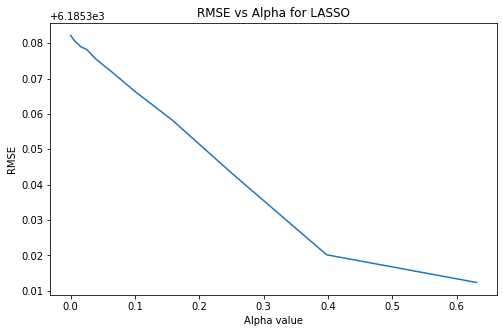

In [124]:
# plot for RMSE vs Alpha for Lasso
scores = (-stats["mean_test_score"])
alpha = stats["param_alpha"]

plt.figure(figsize=(8, 5))
sns.lineplot(alpha, scores)
plt.xlabel('Alpha value')
plt.ylabel('RMSE')
plt.title("RMSE vs Alpha for LASSO")

Best value at 0.6xx ??

In [125]:
print("Best Tuning Parameter:",grid_search.best_params_)
print("Best RMSEscore",-grid_search.best_score_)

Best Tuning Parameter: {'alpha': 0.6309573444801985}
Best RMSEscore 6185.312361079874


In [126]:
data =[{'Model': 'Lasso_with_GridsearchCV','MSE':'--','Tuning Parameters':grid_search.best_params_ ,'RMSE': -grid_search.best_score_ }]
Models_Performance=Models_Performance.append(data, ignore_index=True,sort=False)
Models_Performance

,Model,MSE,Tuning Parameters,RMSE
0,Linear_Regression,33780509.574792,none,5812.100272
1,Lasso,33779702.646641,none,5812.030854
2,Lasso_with_GridsearchCV,--,{'alpha': 0.6309573444801985},6185.312361


In [127]:
ridge = Ridge()
ridge.fit(X_train, y_train)
Ridge_pred=ridge.predict(X_test)

Ridge_MSE, Ridge_RMSE=  mse_rmse(y_test, Ridge_pred)

print("Ridge_MSE =", Ridge_MSE)
print("Ridge_RMSE=", Ridge_RMSE)


data =[{'Model': 'Ridge','MSE':Ridge_MSE,'Tuning Parameters':'--','RMSE': Ridge_RMSE }]
Models_Performance=Models_Performance.append(data, ignore_index=True,sort=False)
Models_Performance

Ridge_MSE = 33779496.76274559
Ridge_RMSE= 5812.013141996978


,Model,MSE,Tuning Parameters,RMSE
0,Linear_Regression,33780509.574792,none,5812.100272
1,Lasso,33779702.646641,none,5812.030854
2,Lasso_with_GridsearchCV,--,{'alpha': 0.6309573444801985},6185.312361
3,Ridge,33779496.762746,--,5812.013142


In [128]:
elastic = ElasticNet(alpha=0.002, l1_ratio= 0.5)
elastic.fit(X_train, y_train)
elastic_pred=elastic.predict(X_test)

elastic_MSE, elastic_RMSE=  mse_rmse(y_test, elastic_pred)

print("elastic_MSE =", elastic_MSE)
print("elastic_RMSE=", elastic_RMSE)


data =[{'Model': 'Elastic','MSE':elastic_MSE,'RMSE': elastic_RMSE }]
Models_Performance=Models_Performance.append(data, ignore_index=True,sort=False)
Models_Performance

elastic_MSE = 33778724.714384176
elastic_RMSE= 5811.946723291962


,Model,MSE,Tuning Parameters,RMSE
0,Linear_Regression,33780509.574792,none,5812.100272
1,Lasso,33779702.646641,none,5812.030854
2,Lasso_with_GridsearchCV,--,{'alpha': 0.6309573444801985},6185.312361
3,Ridge,33779496.762746,--,5812.013142
4,Elastic,33778724.714384,NaN,5811.946723
